In [1]:
# -*- coding: utf-8 -*-
"""
Jet2TT
Use Case 2: Build a Time Series Forecast Model for Inventory Management

author: PNJ
"""

import pandas as pd
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf # ADfuller test
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings

In [2]:
#%%
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#%% Function for running SARIMAX model
def my_forecast(traindata, testdata):
    mod = SARIMAX(traindata, trend='n', order=(3,1,1), seasonal_order=(3,1,1,24))
    results = mod.fit()
    #print(results.summary())

    start1 = testdata.index[0]
    end1 = testdata.index[-1]
    test = results.predict(start=start1 , end=end1, dynamic= True)  
    forecast = results.predict(start=df.shape[0] , end=df.shape[0]+12, dynamic= True)  
    #ans = pd.concat([test,forecast], keys=['test','forecast'], axis=1)
    
    mse = mean_squared_error(testdata, test)
    mae = mean_absolute_error(testdata, test)
    r2score = r2_score(testdata, test)
    ans1 = {'testresult':test, 'forecast':forecast, 'mse':mse, 'mae':mae, 'r2val':r2score}
    return ans1

In [3]:
#%%

#import data , header argument takes care of filling the column headers
df = pd.read_excel('Usecase2_Dataset.xlsx', header=[0,1,2]) 

print(df.head())
print(df.dtypes)

#set part number to index
df = df.set_index(df.columns[0])

#Convert nans to 0
print('before =', df.isnull().sum().sum())
df = df.fillna(0)
print('after =', df.isnull().sum().sum())

# df = df.T

df.columns = df.columns.map('{0[0]}{0[1]}{0[2]}'.format)

# take transpose, easy to work with
df = df.T

# use datetime for index
xx = pd.date_range(start='1/1/2016', periods=206, freq='W')
df = df.set_index(xx)

df = df.apply(pd.to_numeric, errors='coerce')
df = df.fillna(0)
print('after =', df.isnull().sum().sum())

  Unnamed: 0_level_0 2016                                                   \
  Unnamed: 0_level_1  Jan                            Feb                     
             Part No WK 1     2     3     4     5      6     7     8     9   
0           29032636  432  9316  8964  9000  6264  10476  9180  8856  6228   
1           29032635  432  9316  8964  9000  6192  10476  9180  8892  6228   
2           29033235    0     0     0     0     0      0     0     0     0   
3           29033235    0     0     0     0     0      0     0     0     0   
4           29033234    0     0     0     0     0      0     0     0     0   

   ...  2019                                                         
   ...   Oct                           Nov                           
   ...    40    41    42    43    44    44    45    46     47    48  
0  ...  1512  1512  1260  1369   432   180  1404  1332    972  1512  
1  ...  1512  1512  1260  1368   432   180  1404  1332    972  1512  
2  ...  2070  2250  1620 

C:\Users\prana\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys


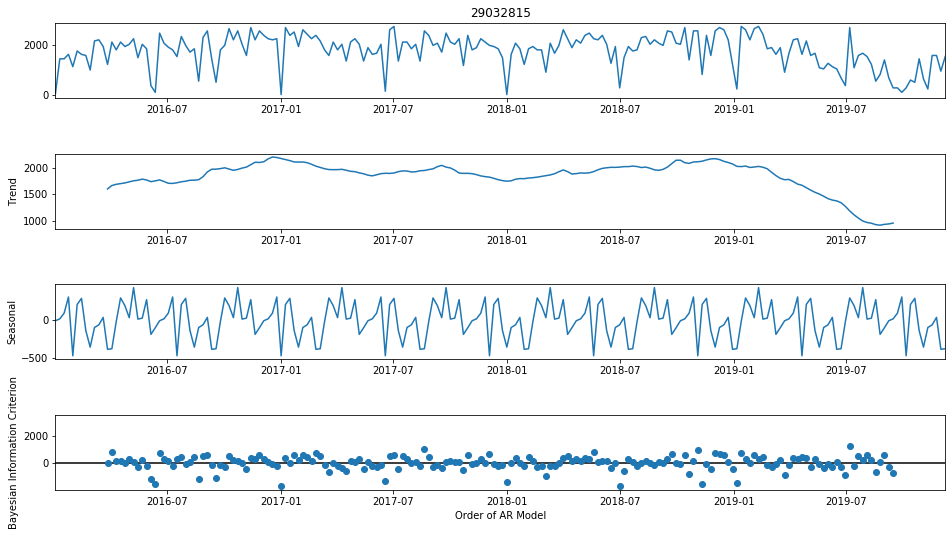

ADF Statistic: -5.044425
p-value: 0.000018


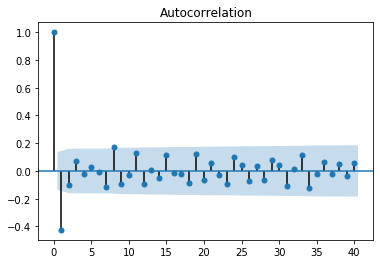

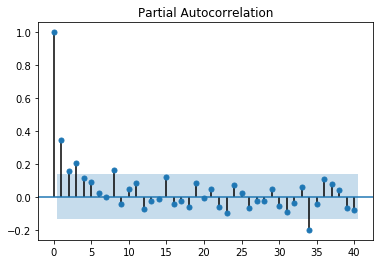

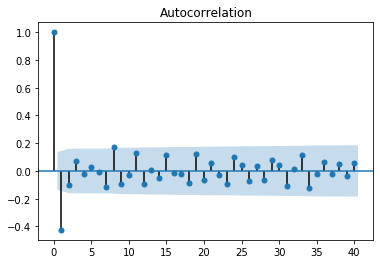

In [4]:
#%%

test = df.iloc[:,14]


# Decompose plot
decomposition = seasonal_decompose(test, freq=24)  
#fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)


# Find best BIC for AR model parameter (p)
BIC = np.zeros(7)
for p in range(7):
    mod = ARIMA(test.values, order=(p,0,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

#%%

"""
Select p,d,q of ARIMA model

p - for AR, no of lag terms = 3
d - differencing , adfuller test = 1
q - for MA, no. of lag errors = 1

"""
#"""
result = adfuller(test)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


# Find p optimal 
plot_pacf(test.values, lags=40)
# from this pacf , p = 3

# Find q optimal 
plot_acf(test.diff().dropna(), lags=40)
#"""

In [5]:
#%% Train and test data

X_train = df.iloc[:-49,]
X_test = df.iloc[-49:,]

C:\Users\prana\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\prana\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2014: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


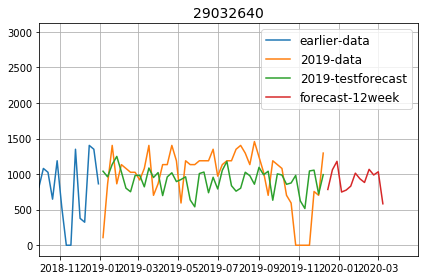

C:\Users\prana\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\prana\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2014: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


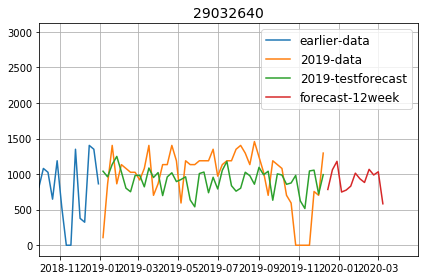

C:\Users\prana\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\prana\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2014: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


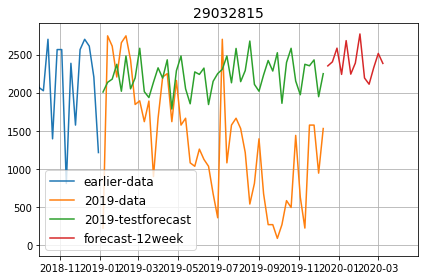

In [9]:
#%%
mse = []
mae = []
r2 = []

for i in df.columns[15:18]: #change the index to plot all columns
    size = X_train[i].shape #some column names are repeated, hence take mean of those columns
    if len(size) >1:
        inp = np.mean(X_train[i], axis=1)
        inptest = np.mean(X_test[i], axis=1)
    else:
        inp = X_train[i]
        inptest = X_test[i]
        
    forecast = my_forecast(inp, inptest)
    # s = ['mse',forecast['mse'], 'mae', forecast['mae'], 'r2', forecast['r2val']]
    mse.append(forecast['mse'])
    mae.append(forecast['mae'])
    r2.append(forecast['r2val'])
    
    # Plot figures 
    
    plt.figure()
    plt.plot(inp, label='earlier-data')
    plt.plot(inptest, label='2019-data')
    plt.plot(forecast['testresult'], label='2019-testforecast')
    plt.plot(forecast['forecast'], label='forecast-12week')
    plt.grid(True)
    plt.title(i,fontsize=14)
    plt.tight_layout()
    plt.xlim([datetime.date(2018, 10, 1), datetime.date(2020, 4, 30)])
    # plt.ylim(0,4000)
    plt.legend(fontsize=12)
    plt.show()
    


In [8]:
print('mean sq error =', mse)
print('mean abs error =', mae)
print('r-squared value =', r2)

mean sq error = [162188.96056805374, 162188.96056805374, 1377322.0441945205]
mean abs error = [324.56176023486927, 324.56176023486927, 979.6663406752298]
r-squared value = [-0.07907752865640916, -0.07907752865640916, -1.4339422210095778]
